In [214]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [215]:
#Descomprimimos el archivo en el que tenemos todos los datos necesarios para la práctica
!unzip /content/drive/MyDrive/Datos/Practica1/archive-intel.zip

Archive:  /content/drive/MyDrive/Datos/Practica1/archive-intel.zip
replace archive-intel/seg_test/seg_test/buildings/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [216]:
# Preparación de las imagenes en crudo en su representación en tensor
from keras.preprocessing.image import ImageDataGenerator
#Con este generador, podremos recorrer los datos en lotes, y en cada iteración, el generador aplicará
#las técnicas de aumento de datos especificadas para generar imágenes aumentadas

In [217]:
#Para normalizar los valores de los píxeles en las imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [218]:
train_generator = train_datagen.flow_from_directory(
    '/content/archive-intel/seg_train/seg_train', #Ruta del directorio donde se encuentran las imágenes de entrenamiento
    target_size=(150, 150), #Las imágenes se redimensionarán a una altura y ancho de 150 píxeles
    batch_size=32, #Número de imágenes en cada lote que se utilizará para el entrenamiento
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 14034 images belonging to 6 classes.


In [219]:
validation_generator = test_datagen.flow_from_directory(
    '/content/archive-intel/seg_test/seg_test', #Ruta del directorio donde se encuentran las imágenes de prueba o validación
    target_size=(150, 150), #Las imágenes se redimensionarán a una altura y ancho de 150 píxeles
    batch_size=32, #Número de imágenes en cada lote que se utilizará para la evaluación
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 3000 images belonging to 6 classes.


In [220]:
# Veamos el contenido de uno de los generators e imprimimos la forma (shape) del lote de datos y el lote de etiquetas
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 6)


In [221]:
#Arquitectura VGG19 como base convolucional, con 19 capas
from keras.applications import VGG19
#Inicializamos el modelo con los pesos preentrenados en el conjunto de datos de ImageNet
#Omitimos la capa densa superior (capa de clasificación) del modelo original
#Especificamos el tamaño de la entrada de las imágenes, 150x150 píxeles y 3 canales (RGB)
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [222]:
#Resumen de la arquitectura de la base convolucional VGG16
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [223]:
#Este enfoque, conocido como "fine-tuning", permite congelar algunas capas y permitir que otras se ajusten durante el entrenamiento

conv_base.trainable = True #Para permitir el ajuste fino en la base convolucional
#Solo se entrenan las últimas 4 capas convolucionales mientras se congelan las demás capas
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    if layer.name == 'block5_conv2':
        layer.trainable = True
    if layer.name == 'block5_conv3':
        layer.trainable = True
    if layer.name == 'block5_conv4':
        layer.trainable = True
    else:
        layer.trainable = False

In [224]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base) #Agregamos la base convolucional VGG19 al modelo
model.add(layers.Flatten()) #Aplanamos para convertir la salida de la base convolucional en un vector unidimensional, preparándola para las capas densas
#model.add(layers.Dense(256, activation='relu')) #Agregamos una capa densa con 64 neuronas y función de activación ReLU
#model.add(layers.Dropout(0.3)) #Añadimos Dropout() para evitar overfitting
model.add(layers.Dense(64, activation='relu')) #Otra capa densa con 256 neuronas y activación ReLU
model.add(layers.Dense(6, activation='softmax')) #Capa de salida con 6 neuronas (tenemos 6 clases), y función de activación softmax porque es clasificación multiclase

In [225]:
#Resumen del modelo
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_12 (Flatten)        (None, 8192)              0         
                                                                 
 dense_33 (Dense)            (None, 64)                524352    
                                                                 
 dense_34 (Dense)            (None, 6)                 390       
                                                                 
Total params: 20549126 (78.39 MB)
Trainable params: 2884550 (11.00 MB)
Non-trainable params: 17664576 (67.39 MB)
_________________________________________________________________


In [226]:
# Configuración del modelo para entrenamiento
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

#La entropía cruzada categórica ('categorical_crossentropy') es comúnmente utilizada en este tipo de problemas (multiclase)
#Utilizamos como optimizador 'RMSprop' con tasa de aprendizaje de 0.001
#Monitoreamos la precisión durante el entrenamiento
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-2), metrics=['acc'])
# Define una función de decaimiento para el learning rate
def learning_rate_scheduler(epoch, lr):
    return lr * 0.95  # Reduce el learning rate en un 5% en cada época

# Compila el modelo con el optimizador Adam y un learning rate inicial
initial_learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

# Define el callback para el learning rate decay
lr_decay_callback = LearningRateScheduler(learning_rate_scheduler, verbose=1)


In [227]:
# Vamos a entrenar la red neuronal con el generator que configuramos más arriba
history = model.fit_generator(train_generator, steps_per_epoch=438, epochs=10, validation_data=validation_generator, validation_steps=93, callbacks=[lr_decay_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/10


<ipython-input-227-d17b05769ad2>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=438, epochs=10, validation_data=validation_generator, validation_steps=93, callbacks=[lr_decay_callback])


438/438 [==============================] - 53s 117ms/step - loss: 1.1790 - acc: 0.7742 - val_loss: 0.4829 - val_acc: 0.8323 - lr: 0.0095

Epoch 2: LearningRateScheduler setting learning rate to 0.009024999709799886.
Epoch 2/10
438/438 [==============================] - 48s 110ms/step - loss: 0.4270 - acc: 0.8512 - val_loss: 0.4481 - val_acc: 0.8474 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008573750033974648.
Epoch 3/10
438/438 [==============================] - 47s 107ms/step - loss: 0.3750 - acc: 0.8687 - val_loss: 0.4239 - val_acc: 0.8528 - lr: 0.0086

Epoch 4: LearningRateScheduler setting learning rate to 0.008145062532275914.
Epoch 4/10
438/438 [==============================] - 48s 109ms/step - loss: 0.3260 - acc: 0.8876 - val_loss: 0.4642 - val_acc: 0.8579 - lr: 0.0081

Epoch 5: LearningRateScheduler setting learning rate to 0.0077378091402351854.
Epoch 5/10
438/438 [==============================] - 47s 108ms/step - loss: 0.3117 - acc: 0.8907 - va

# Vamos a ver las graficas de entrenamiento

In [228]:
history_dict = history.history

In [229]:
#Para obtener las claves disponibles en este diccionario
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

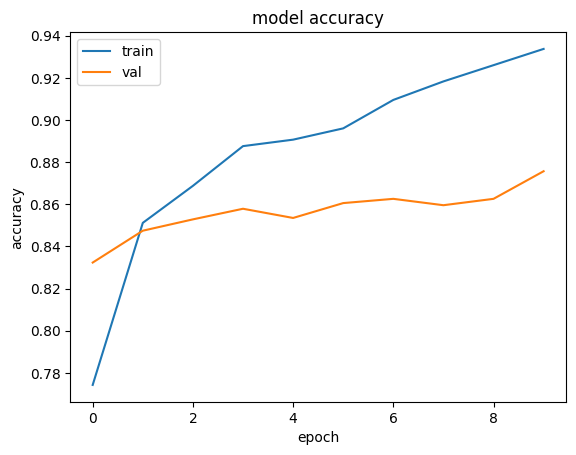

In [230]:
#Gráfica de la precisión del modelo
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy') #Eje y (accuracy): Representa la precisión del modelo
plt.xlabel('epoch') #Eje x (epoch): Representa las épocas del entrenamiento
plt.legend(['train', 'val'], loc='upper left')
plt.show()

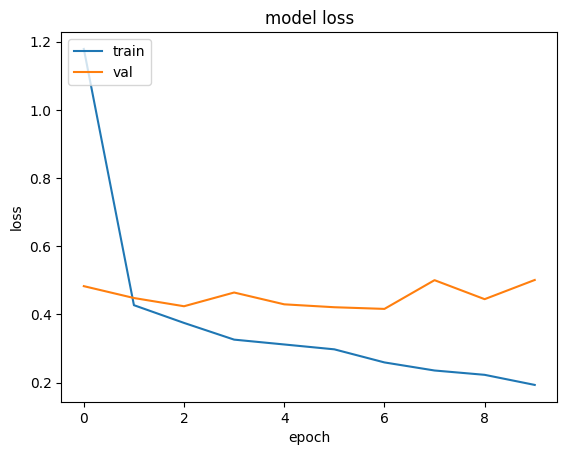

In [231]:
#Gráfica de la pérdida del modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss') #Eje y (loss): Representa la pérdida del modelo
plt.xlabel('epoch') #Eje x (epoch): Representa las épocas del entrenamiento
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [232]:
#Para evaluar el rendimiento del modelo en un conjunto de datos que no se ha visto durante el entrenamiento
test_generator = test_datagen.flow_from_directory(
    '/content/archive-intel/seg_test/seg_test', #Ruta del directorio donde se encuentran las imágenes de prueba
    target_size=(150, 150), #Las imágenes se redimensionarán a una altura y ancho de 150 píxeles
    batch_size=32, #Número de imágenes en cada lote que se utilizará para la evaluación
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 3000 images belonging to 6 classes.


In [233]:
#Estimar la preción al predecir todo el dataset, es decir, evaluamos el rendimiento final del modelo en datos no vistos
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

94/94 [==============================] - 8s 85ms/step - loss: 0.4989 - acc: 0.8760
acc: 87.60%
